In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

torch.cuda.is_available()

False

# Dataset Class

In [12]:
# create a class to get the data set
class DataSet():
    def __init__(self, f_name='card_df.pickle'):
        self.df = pd.read_pickle(f_name)

    def get_image(self, card_name, dim=3):
        path = 'cards/' + card_name +'.png'
        img = Image.open(path)
        img = np.array(img)

        # return the array in the requested dimensions
        if dim == 3:
            return img
        elif dim == 2:
            m,n,l = img.shape
            return img.reshape(m*n, l)
        elif dim == 1:
            return img.flatten()
        else:
            raise ValueError(f"dim must be 1, 2, or 3; got {dim}")

# Test Loading the Data

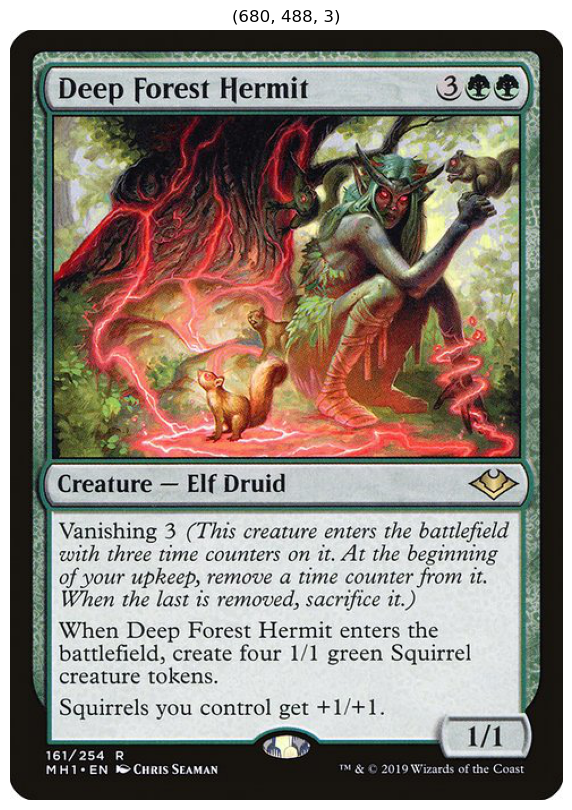

In [78]:
data = DataSet()
name = data.df.sample(1)
card = data.get_image(name['CardName'].values[0])
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(card)
plt.title(card.shape)
plt.show()

# Set up the Model
- We want to use MSELoss() bc that will punish the model greatly for missing the value of a card wildly

In [80]:
# variables we want
loss = nn.MSELoss()